# N<sup>th</sup> Order Sudoku Solver

### All The Libraries

In [6]:
# Visualization Libraries
import matplotlib.pyplot as plt
from tabulate import tabulate

# Other Libraries
from copy import deepcopy
import numpy as np

### This is an Order 3 sudoku problem

there are 6,670,903,752,021,072,936,960 (6.671×10<sup>21</sup>) valid Sudoku squares of order 3.

I will be using the AllDifferent constraint method to solve this problem, also implementing Hyper-Arc Consistency Algorithm on the constraint variables

### Declarations

In [7]:
# Predefined sudoku puzzle, with select few bad entries
sudoku = [[3, 7, 3, 2, 4, 5, 8, 6, 1],
          [2, 8, 5, 3, 6, 1, 9, 7, 4],
          [1, 6, 4, 9, 7, 8, 2, 3, 5],
          [9, 5, 8, 6, 3, 4, 1, 2, 7],
          [4, 3, 7, 1, 9, 2, 6, 5, 8],
          [6, 2, 1, 8, 5, 7, 4, 9, 3],
          [7, 9, 2, 4, 1, 3, 5, 8, 6],
          [8, 4, 3, 5, 2, 6, 7, 1, 9],
          [5, 1, 6, 7, 8, 9, 3, 4, 2]]

# The order of current sudoku problem
order = 3

# Storing all unique variables
variables = np.arange(1, order ** 2 + 1)

# Variable that decides whether to use Dancing Links (DLX) algorithm or backtracking
USE_DLX = True

### Helper Functions

In [8]:
def get_subgrids(grid: 'Any' = None) -> list:
    '''
    Takes in a grid of any size (could be a list or numpy array). Also
    uses the global variable order. First, it converts the passed grid
    to a numpy array, if not already a numpy array. Then stores all the
    sub-grids into a new list by computing based on x and y: calculated
    by dividing rows (x) and cols (y) by the order of our puzzle. Then,
    returns that newly created list of sub-grids.
    '''
    
    global order
    
    np_grid = np.array(grid)        # x and y represent the index of the
    x, y = np_grid.shape            # sub-grids, calculated by dividing
    x, y = x // order, y // order   # the shape by order.
    
    subgrids = list()

    for i in range(x):                                                   # Loop over each subgrid index and
        for j in range(y):                                               # using the sub-grid indexes and order 
            subgrids.append(np_grid[i * x: i * x + x, j * y: j * y + y]) # in array slicing to store sub-grids
                                                                         # into a new list.
    return subgrids


def display(grid: 'Any' = None):
    '''
    Takes in a grid of any size (could be a list or numpy array). Uses
    built in tabulate library to format the output neatly in a table.
    '''
    
    board = tabulate(grid, tablefmt = 'fancy_grid')
    print(board)


def print_solution(grid: 'Any' = None, count: int = 0):
    '''
    Takes in a grid of any size (could be a list or numpy array) and an
    integer count (which represents the number of corrected entries). It
    just prints the solution by calling the display function and passing
    the grid as its parameter. It also raises a runtime error if the grid
    passed is a none type object.
    '''
    
    if grid is not None:
        print(f"{'Solved puzzle:' : >26}")
        display(grid)
        print('\033[94m' + '\033[1m' + f'\nCORRECTED ENTRIES: {count}' + '\033[0m')
    else:
        raise RuntimeError("Puzzle is improbable. Unable to find a solution!")


def plot_grid(grid: 'Any' = None, count: int = 0):
    '''
    Takes in a grid of any size (could be a list or numpy array) and an
    integer count (which represents the number of corrected entries). Also
    uses the global variable order. First, it converts the passed grid to
    a numpy array, if not already a numpy array. Creates a numpy array of
    colors and maps each index to a color. These colors are then assigned
    to each of the numbers in the grid: 9 being darkest, 1 being lightest.
    Colors are also assigned by calculation based on the order of puzzle.
    
    '''
    
    print('\033[1m' + '\nPrinting the black & white temperature GRID for visual purposes' + '\033[0m')
    print('\n', '\033[95m' + '\033[1m' + f"{'B & W color temperature grid' : >45}" + '\033[0m')
    
    np_grid = np.array(grid)

    global order
    
    colors = np.zeros((order ** 2, order ** 2))

    for i in range(order):                                                                    # Loop over each sub-grid
        for j in range(order):                                                                # and assign 0s in one sub
            colors[i * order: i * order + order, j * order: j * order + order] = (i + j) % 2  # grid and 1s in another.
                                                                                              # Keep repeating that.
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.imshow(np_grid, cmap = 'gray_r')

    for i in range(order ** 2):                                                                        # Loop over each index
        for j in range(order ** 2):                                                                    # one by one, and if
            if colors[i, j] == 1:                                                                      # you're at the sub-grid
                rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill = False, lw = 2)                   # that has 1s, plot rect
            ax.text(j, i, np_grid[i, j], ha = 'center', va = 'center', fontsize = 16, color = 'black') # and fill with color,
                                                                                                       # with ± .5 shifts 
    plt.show()
    print('\033[95m' + '\033[1m' + f"{f'CORRECTED ENTRIES: {count}': >41}" + '\033[0m')

### Utility Functions

In [9]:
def row_check(grid: 'Any' = None) -> list:
    '''
    Takes in a grid of any size (could be a list or numpy array). Does
    list comprehension on the grid, storing the idx of the row which
    contains a duplicate value. Prints the # of invalid rows, and also
    the specific rows that are invalid. Returns the list of invalid rows.
    '''
    
    inv_rows = [idx for idx, row in enumerate(grid) if len(set(row)) != variables.size or 0 in row] # Check if length of set row
                                                                                                    # equal to # of variables.
    print('Number of invalid rows     : ', len(inv_rows))                                           # if not, it is incorrect.
    print('Rows that are invalid      : ', ', '.join(map(str, inv_rows)))
    
    return inv_rows


def col_check(grid: 'Any' = None) -> list:
    '''
    Takes in a grid of any size (could be a list or numpy array). Then
    tranposes that grid so that columns become rows. Then it Does same
    list comprehension on the grid, storing the idx of the row which
    contains a duplicate value (keep in mind that now, that row points
    to that column number). Prints the # of invalid cols, and also the
    specific cols that are invalid. Returns the list of invalid cols.
    '''
    
    transposed_grid = np.array(grid).T.tolist()
    inv_cols = [idx for idx, col in enumerate(transposed_grid) if len(set(col)) != variables.size or 0 in col] # Check if length
                                                                                                               # of col equal to
    print('Number of invalid cols     : ', len(inv_cols))                                                      # # of variables.
    print('Cols that are invalid      : ', ', '.join(map(str, inv_cols)))                                      # if not, it is
                                                                                                               # incorrect.
    return inv_cols
 
    
def subgrid_check(grid: 'Any' = None) -> list:
    '''
    Takes in a grid of any size (could be a list or numpy array). Passes
    that grid to a predefined function get_subgrids which returns the list
    of all sub-grids. Does list comprehension on the list of sub-grids,
    flattens each sub-grid and stores the (idx + 1) of the sub-grid that
    contains a duplicate value. Prints the # of invalid sub-grids, and also
    the specific sub-grids that are invalid. Returns the list of invalid
    sub-grids.
    '''                                                                         # Check if length of flattened sub-grid
                                                                                # is equal to # of variables. if not, it
    subgrids = get_subgrids(grid)                                               # is incorrect.
    
    inv_sub = [idx + 1 for idx, subgrid in enumerate(subgrids) if len(set(subgrid.flatten())) != variables.size or 0 in subgrid]
    
    print('Number of invalid subgrids : ', len(inv_sub))
    print('Subgrids that are invalid  : ', ', '.join(map(str, inv_sub)))
    
    return inv_sub


def final_check(solution: 'Any' = None):
    '''
    Takes in a solution grid of any size (could be a list or numpy array).
    Calls all the constrain checking functions on that solution grid. If
    all functions return empty lists, then all constrains have been passed.
    '''
    
    print('\033[1m' + '\x1B[4m' + '\nRechecking the solution GRID for all constraints\n' + '\x1B[0m' + '\033[0m')
    if (
        len(row_check(solution)) == 0 and  # Checking if len of all returned
        len(col_check(solution)) == 0 and  # lists are 0.
        len(subgrid_check(solution)) == 0
       ):
        print('\033[94m' + '\033[1m' + '\nThis particular solution has passed all the constraints' + '\033[0m')
        return
    print('\033[94m' + '\033[1m' + '\nThis particular solution has failed to pass all the constrains' + '\033[0m')


def validate(row: 'Any', col: 'Any', candidate: int, row_idx: int, col_idx: int, grid: 'Any') -> bool:
    '''
    Takes in entire row and its index, entire col and its index, a candidate
    number and also a grid of any size (could be a list or numpy array) as its
    arguments. Checks if the candidate number is present in any row, col or the
    sub-grid of those (row, col) indexes. If, candidate is in any of those, it
    returns false, otherwise true.
    '''
    
    global order
    np_grid = np.array(grid)

    if candidate in row:
        return False

    if candidate in col:
        return False

    grid_row = (row_idx // order) * order # Storing the starting row and col of
    grid_col = (col_idx // order) * order # sub-grid of given index of value.
                                                                            
    sub = np_grid[grid_row: grid_row + order, grid_col: grid_col + order] # Using those starting rows and cols,
    if candidate in sub:                                                  # creating the sub-grid, and checking
        return False                                                      # if candidate in that sub-grid.

    return True


def create_solvable_puzzle(grid: 'Any' = None) -> list or np.ndarray:
    '''
    Takes in a grid of any size (could be a list or numpy array). Calls all
    the constrain checking functions on that passed grid, and stores the
    incorrect rows, cols and sub-grids. Also it transposes the grid, stores
    it into t_grid. Iterates over all incorrect rows and stores the repeated
    values in that row in row_dup. Then, for each incorrect row, iterate over
    all incorrect cols and also store the repeated values in that col. Then,
    store the common elements in those by taking their intersection. If there
    is no common, just skip that col. If there are common elements, then loop
    over each common element. For each common element, reiterate over that
    specific row, and match the common element with the value. iF matched,
    then check whether that column of the matched value contains more of that
    element. If yes, then remove it (by replacing it with 0). Repeat process
    untill all incorrect rows and cols have been iterated. Returns the new
    grid.
    '''
    
    inv_rows = row_check(grid)
    inv_cols = col_check(grid)
    inv_sub = subgrid_check(grid)
    
    t_grid = np.array(grid).T.tolist()
    
    for row in inv_rows:                                                          # In this nested loop, we iterate over
        row_dup = np.sort(grid[row], axis = None)                                 # each incorrect row and store the 
        row_dup = set(row_dup[: -1][ row_dup[1:] == row_dup[: -1]].tolist())      # duplicate values. Then we iterate over
        for col in inv_cols:                                                      # each incorrect column amd store its
            col_dup = np.sort(t_grid[col], axis = None)                           # duplicate values. We store the same
            col_dup = set(col_dup[: -1][ col_dup[1:] == col_dup[: -1]].tolist())  # duplicate values. For each common value
                                                                                  # We reiterate over the values in each row
            common = row_dup.intersection(col_dup)                                # and match them to the common value. If 
                                                                                  # found, we check if that value is repeated
            if not common:                                                        # in that column using the index. If yes,
                pass                                                              # we remove it by assigning 0 to it.
            
            for value in common:
                for idx, match in enumerate(grid[row]):
                    if value == match:
                        if t_grid[idx].count(value) > 1:
                            grid[row][idx] = 0
            
    return grid

## Solving Functions

In [10]:
def solve_dancinglinks(grid: 'Any' = None) -> tuple[list or np.ndarray or None, int or None]:
    """Sudoku solver using Knuth's Algorithm X with Dancing Links (DLX).
    
    Args:
        grid: Input Sudoku grid as list or numpy array. Can contain 0s for empty cells.
        
    Returns:
        tuple: (solved_grid, corrected_entries_count) if solvable, (None, None) if unsolvable.
        
    Notes:
        - Preserves same signature and return values as original solve function
        - Works in-place so callers that don't capture return still get filled grid
        - Supports generalized Sudoku of size (order^2) x (order^2)
    """
    global order
    global variables
    
    class Node:
        """Node in the Dancing Links structure representing a matrix element."""
        
        __slots__ = ("L", "R", "U", "D", "C", "row", "r", "c", "n")
        
        def __init__(self):
            """Initialize node with circular links pointing to itself."""
            self.L = self
            self.R = self
            self.U = self
            self.D = self
            self.C = None

            self.row = None
            self.r = None
            self.c = None
            self.n = None
    
    class Column(Node):
        """Column header node with size tracking."""
        
        __slots__ = ("S", "name")
        
        def __init__(self, name=None):
            """Initialize column header.
            
            Args:
                name: Optional identifier for the column.
            """
            super().__init__()
            self.S = 0
            self.name = name
            
    def link_right(left: Node, right: Node):
        """Link two nodes horizontally in the circular list.
        
        Args:
            left: Left node in the chain.
            right: Right node to insert after left.
        """
        right.R = left.R
        right.R.L = right
        right.L = left
        left.R = right
    
    def link_down(col: Column, node: Node):
        """Insert node at bottom of column's vertical list.
        
        Args:
            col: Column header to insert into.
            node: Node to insert.
        """
        node.D = col
        node.U = col.U
        col.U.D = node
        col.U = node
        node.C = col
        col.S += 1
    
    def iterate_down(col: Column):
        """Iterate through nodes in a column from top to bottom.
        
        Args:
            col: Column to iterate through.
            
        Yields:
            Node: Each node in the column.
        """
        n = col.D
        while n is not col:
            yield n
            n = n.D
    
    def iterate_right(row_node: Node):
        """Iterate through nodes in a row from left to right.
        
        Args:
            row_node: Starting node in the row.
            
        Yields:
            Node: Each node in the row.
        """
        n = row_node.R
        while n is not row_node:
            yield n
            n = n.R
    
    def iterate_left(row_node: Node):
        """Iterate through nodes in a row from right to left.
        
        Args:
            row_node: Starting node in the row.
            
        Yields:
            Node: Each node in the row.
        """
        n = row_node.L
        while n is not row_node:
            yield n
            n = n.L
    
    def cover(col: Column):
        """Cover a column by removing it and all intersecting rows.
        
        Args:
            col: Column to cover.
        """
        # Remove column header from the horizontal list
        col.R.L = col.L
        col.L.R = col.R
        
        # For each row with a 1 in this column, remove that row from other columns
        i = col.D
        while i is not col:
            j = i.R
            while j is not i:
                j.D.U = j.U
                j.U.D = j.D
                # Decrement column size
                j.C.S -= 1  
                j = j.R
            i = i.D
            
    def uncover(col: Column):
        """Uncover a column by restoring it and all intersecting rows.
        
        Args:
            col: Column to uncover.
        """
        # Reverse the cover operation: restore rows in reverse order
        i = col.U
        while i is not col:
            j = i.L
            while j is not i:
                # Restore column size
                j.C.S += 1
                j.D.U = j
                j.U.D = j
                j = j.L
            i = i.U
        # Restore column header to horizontal list
        col.R.L = col
        col.L.R = col
    
    def choose_column() -> Column:
        """Choose column with smallest size for branching efficiency.
        
        Returns:
            Column: Column with minimum number of nodes.
        """
        # Heuristic: choose column with smallest number of 1s for efficiency
        c = H.R
        best = c
        while c is not H:
            if c.S < best.S:
                best = c
            c = c.R
        return best
    
    def col_cell(r, c):
        """Get column index for cell constraint.
        
        Args:
            r: Row index.
            c: Column index.
            
        Returns:
            int: Column index for this cell constraint.
        """
        return r * N + c
    
    def col_rownum(r, n):
        """Get column index for row-number constraint.
        
        Args:
            r: Row index.
            n: Number (0-based).
            
        Returns:
            int: Column index for this row-number constraint.
        """
        return N*N + r * N + n
    
    def col_colnum(c, n):
        """Get column index for column-number constraint.
        
        Args:
            c: Column index.
            n: Number (0-based).
            
        Returns:
            int: Column index for this column-number constraint.
        """
        return 2*N*N + c * N + n
    
    def col_boxnum(b, n):
        """Get column index for box-number constraint.
        
        Args:
            b: Box index.
            n: Number (0-based).
            
        Returns:
            int: Column index for this box-number constraint.
        """
        return 3*N*N + b * N + n
    
    def box_index(r, c):
        """Calculate box index from row and column coordinates.
        
        Args:
            r: Row index.
            c: Column index.
            
        Returns:
            int: Box index (0-based).
        """
        return (r // order) * order + (c // order)
    
    def select_row(rnode: Node):
        """Select a row by covering all its columns (used for givens).
        
        Args:
            rnode: Representative node from the row to select.
        """
        cover(rnode.C)
        j = rnode.R
        while j is not rnode:
            cover(j.C)
            j = j.R
            
    def search():
        """Recursive search function implementing Algorithm X.
        
        Returns:
            bool: True if solution found, False otherwise.
        """
        nonlocal solved_nodes
        
        # If no columns remain, we've satisfied all constraints
        if H.R is H:
            solved_nodes = O.copy()
            return True
            
        # Choose the most constrained column for efficiency
        c = choose_column()
        if c.S == 0:
            # Dead end: no way to satisfy this constraint
            return False
        
        cover(c)
        rnode = c.D
        while rnode is not c:
            # Select this row
            O.append(rnode)
            
            # Cover all columns this row intersects
            j = rnode.R
            while j is not rnode:
                cover(j.C)
                j = j.R
                
            # Recurse: try to solve with this choice
            if search():
                return True
                
            # Backtrack: uncover in reverse order
            j = rnode.L
            while j is not rnode:
                uncover(j.C)
                j = j.L
                
            # Remove this row from selection
            O.pop()
            rnode = rnode.D
            
        uncover(c)
        return False
    
    if grid is None:
        raise RuntimeError("No grid was provided to solve().")
    
    # Normalize board to a Python list of lists while preserving original reference
    isnp = isinstance(grid, np.ndarray)
    
    # e.g., order=3 -> N=9
    N = order ** 2
    
    if isnp:
        board = grid.tolist()
    else:
        # Deep copy to avoid aliasing
        board = [list(row) for row in grid]
    
    # Count empty cells for the "corrected entries" metric
    initial_zeros = sum(1 for r in range(N) for c in range(N) if board[r][c] == 0)
    
    # Create header sentinel for the circular list of column headers
    H = Column("H")
    
    # Four constraint types: Cell, Row-Num, Col-Num, Box-Num
    n_columns = 4 * N * N
    columns = [Column(name=k) for k in range(n_columns)]
    
    # Link all columns into a horizontal circular list
    last = H
    for col in columns:
        # Initialize vertical circular list
        col.U = col.D = col
        link_right(last, col)
        last = col
    
    # Build the exact cover matrix: each candidate (r,c,n) creates one row
    # Store one representative node per row
    rows_nodes = []
    row_id = 0
    
    # For each cell, create candidate rows based on givens or all possibilities
    for r in range(N):
        for c in range(N):
            given = board[r][c]
            # If given, only one candidate; otherwise all numbers 1-N
            candidates = [given - 1] if given != 0 else list(range(N))
            b = box_index(r, c)
            
            # n is 0-based number
            for n in candidates:
                # Each candidate satisfies four constraints
                col_ids = (
                    col_cell(r, c),      # This cell must be filled
                    col_rownum(r, n),    # Row r must contain number n+1
                    col_colnum(c, n),    # Column c must contain number n+1
                    col_boxnum(b, n)     # Box b must contain number n+1
                )
                
                # Create nodes for this row and link them horizontally
                first = None
                prev = None
                new_nodes = []
                
                for cid in col_ids:
                    node = Node()
                    node.row = row_id
                    # Store placement info
                    node.r, node.c, node.n = r, c, n
                    link_down(columns[cid], node)
                    
                    if first is None:
                        first = node
                        # Initialize horizontal cycle
                        node.R = node.L = node
                    else:
                        # Link horizontally in circular fashion
                        node.R = first
                        node.L = prev
                        prev.R = node
                        first.L = node
                    prev = node
                    new_nodes.append(node)
                    
                rows_nodes.append(first)
                row_id += 1
    
    # Preselect given values by covering their corresponding rows
    # Solution stack: stores one node from each selected row
    # Quick lookup: (r,c,n) -> representative node
    O = []  
    rc_lookup = {}  
    for rnode in rows_nodes:
        rc_lookup.setdefault((rnode.r, rnode.c, rnode.n), rnode)
        
    for r in range(N):
        for c in range(N):
            v = board[r][c]
            # This cell has a given value
            if v != 0:
                # Convert to 0-based
                key = (r, c, v-1)
                rnode = rc_lookup.get(key)
                if rnode is None:
                    # Invalid given value
                    return None, None
                # Cover all columns this row satisfies
                select_row(rnode)
                O.append(rnode)
    
    # Run Algorithm X to find exact cover
    solved_nodes = None
    
    if not search():
        # No solution exists
        return None, None
    
    # Decode the solution back into a grid
    solved = [[0]*N for _ in range(N)]
    for node in solved_nodes:
        # Convert back to 1-based
        solved[node.r][node.c] = node.n + 1
    
    # Write solution back to original grid object (in-place operation)
    if isnp:
        grid[:, :] = np.array(solved)
    else:
        for r in range(N):
            for c in range(N):
                grid[r][c] = solved[r][c]
    
    # Count cells that were originally 0 and are now filled
    count = sum(1 for r in range(N) for c in range(N) if solved[r][c] != 0 and board[r][c] == 0)
    
    return grid, count

def solve_backtracking(grid: 'Any' = None) -> tuple[list or np.ndarray or None, int or None]:
    '''
    Takes in a grid of any size (could be a list or numpy array). Also uses
    global variables and order. Has a nested backtracking function as well.
    Uses that to solve the puzzle. Returns the solved grid, and also the
    number of corrected entries.
    '''
    
    global variables
    global order
    count = 0
    
    def recurse() -> bool:
        '''
        Takes in no argument. A recursive function inside the parent function
        solve, that uses the nonlocal count variable (defined in its parent
        function). Implements the allDifferent constraint method to recursively
        come up with a solution. One by one insert a valid candidate into the
        empty spaces (defined by 0s) and recurse through the solution. If 
        recurse was true, do it again, if false then replace the candidate with
        a zero, and back track until a correct candidate is inserted. This loop
        ensures the Hyper-Arc Consistency theorem on the constraint variables.
        Returns True if candidate fits, else false.
        '''
        nonlocal count
        t_grid = np.array(grid).T.tolist()
        
        for row_idx, row in enumerate(grid):                                                   # In this nested loop, we check
            for col_idx, value in enumerate(row):                                              # for zeroes in the grid. If
                if value == 0:                                                                 # found, then we check which
                    for candidate in variables:                                                # candidate value is a best fit
                        if validate(row, t_grid[col_idx], candidate, row_idx, col_idx, grid):  # in that index. We replace it,
                            grid[row_idx][col_idx] = candidate                                 # increment the counter, and 
                            count = count + 1                                                  # recurse to the solution again.
                            if recurse():
                                return True
                            count = count - 1           # Count is decremented if the solution back-tracks and
                            grid[row_idx][col_idx] = 0  # removes the placed candidate with zero. This ensures
                    return False                        # the number of corrected entries are accurate.
                
        return True

    if recurse():
        return grid, count
    else:
        return None, None

### Driver Functions

In [11]:
def solve(grid: 'Any' = None) -> tuple[list or np.ndarray or None, int or None]:
    '''
    Wrapper function to choose between backtracking and Dancing Links (DLX)
    based on the global USE_DLX variable. Takes in a grid of any size (could
    be a list or numpy array). Returns the solved grid, and also the number
    of corrected entries.
    '''
    if USE_DLX:
        return solve_dancinglinks(grid)
    else:
        return solve_backtracking(grid)

def create_grid(percent: float = 10.0) -> list or np.ndarray:
    '''
    Takes in a percentage variable as its parameters. Percentage
    is used to calculate the number of zeroes to put in the grid.
    Also uses global order nad variables. Applies constraint on
    percentage. Creates a new numpy array of size (defined by order)
    of zeros. loops over the (order*order) diagonals, and for each
    diagonal, computes a random permutation of the variables, inserts
    those values in the diagonals. After all diagonals, call the solve
    function to insert correct values in the function using recursion.
    Then, use the percentage variable to randomly remove _ percent of
    variables from that correct puzzle. Returns the generated puzzle.
    '''
    
    if percent < 0 or percent > 100:
        raise ValueError('Percentage must be in range [0, 100]') 
    
    global variables
    global order
    
    new_puzzle = np.zeros((order ** 2, order ** 2), dtype = int)
    
    if percent == 100:
        return new_puzzle
    
    for diagonal in range(order):                                                            # In this loop, we iterate over
        idx = 0                                                                              # each (order * order) sub-grids.
        candidate = np.random.permutation(variables)                                         # We insert correct random values
        for row in range(order):                                                             # in that grid.
            for col in range(order):
                new_puzzle[diagonal * order + row, diagonal * order + col] = candidate[idx]
                idx = idx + 1
                
    solve(new_puzzle)
    
    zeros = int(float(percent / 100) * new_puzzle.size)
    
    for _ in range(zeros):                              # In this loop, we randomely select
        row, col = np.random.randint(0, order ** 2, 2)  # a row and col (index) to remove the
        new_puzzle[row, col] = 0                        # value from.

    return new_puzzle

### Main

#### FIRST implementation using the random grid creation function

Statistics for the created sudoku puzzle: 

Number of invalid rows     :  6
Rows that are invalid      :  0, 1, 2, 3, 4, 5
Number of invalid cols     :  8
Cols that are invalid      :  0, 1, 2, 3, 4, 5, 6, 8
Number of invalid subgrids :  6
Subgrids that are invalid  :  1, 2, 3, 4, 5, 6

      Original created puzzle:
╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 8 │ 0 │ 6 │ 4 │ 1 │ 0 │ 3 │ 9 │ 2 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 4 │ 5 │ 2 │ 0 │ 6 │ 3 │ 7 │ 8 │ 1 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 9 │ 1 │ 3 │ 0 │ 8 │ 2 │ 0 │ 5 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 0 │ 6 │ 0 │ 2 │ 5 │ 8 │ 9 │ 7 │ 3 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 3 │ 9 │ 5 │ 1 │ 0 │ 0 │ 0 │ 2 │ 0 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 0 │ 7 │ 3 │ 9 │ 0 │ 1 │ 6 │ 5 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 6 │ 3 │ 8 │ 5 │ 4 │ 9 │ 2 │ 1 │ 7 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 5 │ 4 │ 1 │ 8 │ 2 │ 7 │ 6 │ 3 │ 9 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 7 │ 2 │ 9 │ 6 │ 3 │ 1 │ 5 │ 4 │ 8

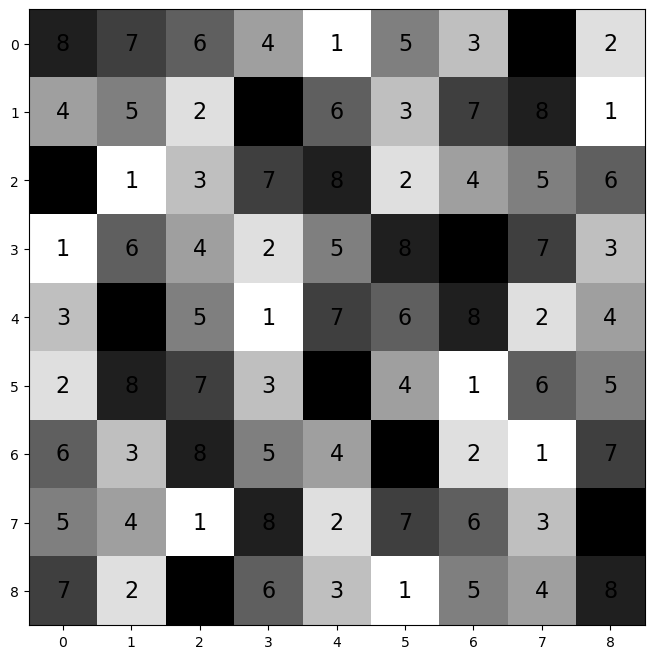

                    CORRECTED ENTRIES: 14

Rechecking the solution GRID for all constraints

Number of invalid rows     :  0
Rows that are invalid      :  
Number of invalid cols     :  0
Cols that are invalid      :  
Number of invalid subgrids :  0
Subgrids that are invalid  :  

This particular solution has passed all the constraints


In [12]:
# Takes in a percentage corresponding to number of wrong entries
puzzle = create_grid(20.0)

print('\033[1m' + '\x1B[4m' + 'Statistics for the created sudoku puzzle:' + '\x1B[0m' + '\033[0m', '\n')
row_check(puzzle)
col_check(puzzle)
subgrid_check(puzzle)
print()

print(f"{'Original created puzzle:' : >30}")
display(puzzle)

solved, entries = solve(puzzle)

print_solution(solved, entries)
plot_grid(solved, entries)
final_check(solved)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### SECOND implementation using the grid provided and modifying the grid ourselves

Statistics for the original sudoku puzzle: 

Number of invalid rows     :  1
Rows that are invalid      :  0
Number of invalid cols     :  1
Cols that are invalid      :  2
Number of invalid subgrids :  1
Subgrids that are invalid  :  1

       Original sudoku puzzle:
╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 3 │ 7 │ 3 │ 2 │ 4 │ 5 │ 8 │ 6 │ 1 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 8 │ 5 │ 3 │ 6 │ 1 │ 9 │ 7 │ 4 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 6 │ 4 │ 9 │ 7 │ 8 │ 2 │ 3 │ 5 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 9 │ 5 │ 8 │ 6 │ 3 │ 4 │ 1 │ 2 │ 7 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 4 │ 3 │ 7 │ 1 │ 9 │ 2 │ 6 │ 5 │ 8 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 6 │ 2 │ 1 │ 8 │ 5 │ 7 │ 4 │ 9 │ 3 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 7 │ 9 │ 2 │ 4 │ 1 │ 3 │ 5 │ 8 │ 6 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 8 │ 4 │ 3 │ 5 │ 2 │ 6 │ 7 │ 1 │ 9 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 5 │ 1 │ 6 │ 7 │ 8 │ 9 │ 3 │ 4 │ 2 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛
         

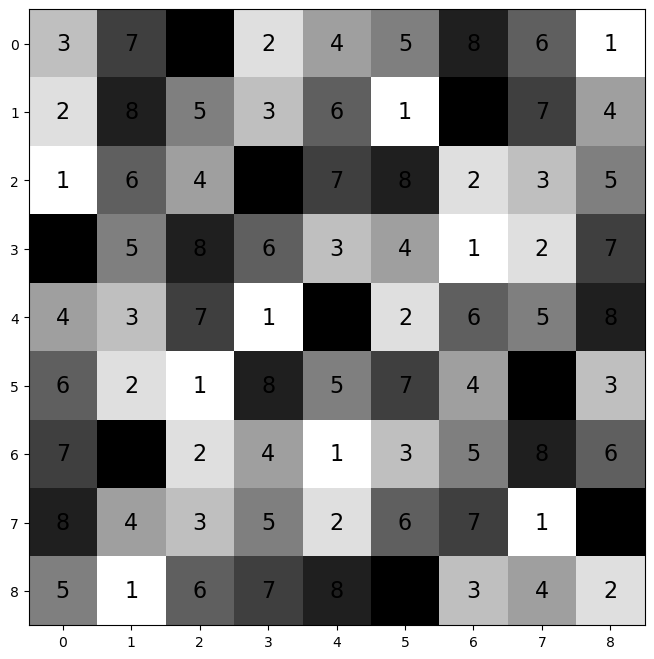

                     CORRECTED ENTRIES: 1

Rechecking the solution GRID for all constraints

Number of invalid rows     :  0
Rows that are invalid      :  
Number of invalid cols     :  0
Cols that are invalid      :  
Number of invalid subgrids :  0
Subgrids that are invalid  :  

This particular solution has passed all the constraints


In [13]:
print('\033[1m' + 'Statistics for the original sudoku puzzle:' + '\033[0m', '\n')
solvable_puzzle = create_solvable_puzzle(deepcopy(sudoku))
print()

print(f"{'Original sudoku puzzle:' : >30}")
display(sudoku)

answer, corrections = solve(solvable_puzzle)

print_solution(answer, corrections)
plot_grid(answer, corrections)
final_check(answer)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## I also studied a paper published on this particular problem.  Below is the citation:

 Simonis, Helmut (2005). "Sudoku as a Constraint Problem". Cork Constraint Computation Centre at University College Cork: Helmut Simonis. CiteSeerX 10.1.1.88.2964. paper presented at the Eleventh International Conference on Principles and Practice of Constraint Programming

link: https://citeseerx.ist.psu.edu/doc/10.1.1.88.2964